In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data_large.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [5]:
import random


class NNRegressor(L.LightningModule):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, optimizer=torch.optim.Adam, lr=1e-3, weight_decay=1e-4, target_scaler=None):
        super(NNRegressor, self).__init__()
        self.target_scaler = target_scaler
        self.optimizer = optimizer
        self.lr = lr
        self.weight_decay = weight_decay
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

        self.loss_metric = MeanSquaredError()
        self.val_metric = MeanSquaredError()
        self.test_metric = MeanSquaredError()



    def forward(self, x):
        y = self.network(x)
        return y
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.to(self.device)
        y = y.to(self.device)
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_mse", self.loss_metric(y_hat, y), prog_bar=True)

        return loss
    
    def on_training_epoch_end(self):
        self.log("train_mse", self.loss_metric.compute())
        self.loss_metric.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_mse", self.val_metric(y_hat, y), prog_bar=True)

    def on_validation_epoch_end(self):
        self.log("val_mse", self.val_metric.compute())
        self.val_metric.reset()
        
    def configure_optimizers(self):
        return self.optimizer(self.network.parameters(), lr=self.lr, weight_decay=self.weight_decay)
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.functional.mse_loss(y_hat, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_mse", self.test_metric(y_hat, y), prog_bar=True)
        return loss
    
    def on_test_epoch_end(self):
        self.log("test_mse", self.test_metric.compute())
        self.test_metric.reset()

simple_nn = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
)

In [ ]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
NNRegressor                              [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 1978]                 1,958,220
│    └─BatchNorm1d: 2-2                  [1, 1978]                 3,956
│    └─LeakyReLU: 2-3                    [1, 1978]                 --
│    └─Dropout: 2-4                      [1, 1978]                 --
│    └─Linear: 2-5                       [1, 3956]                 7,828,924
│    └─BatchNorm1d: 2-6                  [1, 3956]                 7,912
│    └─LeakyReLU: 2-7                    [1, 3956]                 --
│    └─Dropout: 2-8                      [1, 3956]                 --
│    └─Linear: 2-9                       [1, 7912]                 31,307,784
│    └─BatchNorm1d: 2-10                 [1, 7912]                 15,824
│    └─LeakyReLU: 2-11                   [1, 7912]   

: 

In [ ]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = NNRegressor(
    input_dim=len(cancer_dm.ds_train[0][0]),
    n_layers=8,
    target_scaler=target_scaler,
)
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 332 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
332 M     Trainable params
0         Non-trainable params
332 M     Total params
1,330.783

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     0.934044361114502     │
│         test_mse          │     0.934044361114502     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.934044361114502, 'test_mse': 0.934044361114502}]

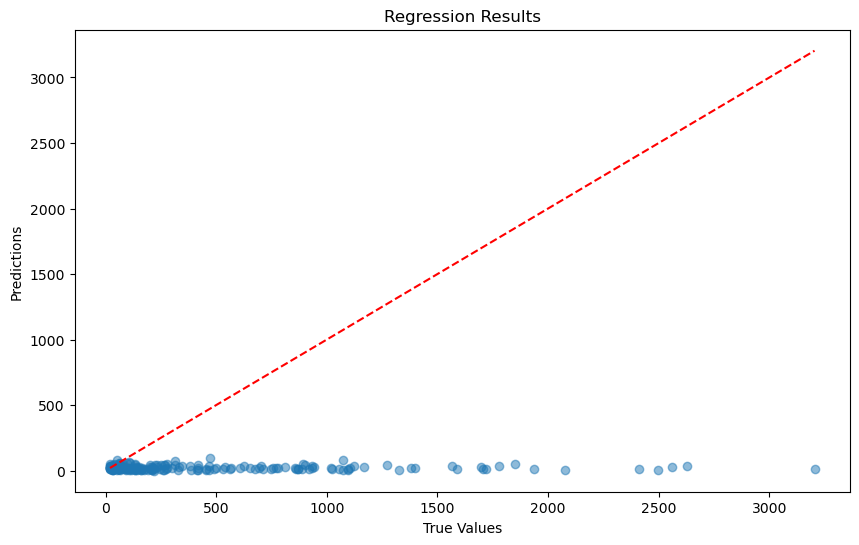

In [ ]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [ ]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 10)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=n_layers,
        dropout=dropout,
        activation=activation,
        optimizer=optimizer,
        lr=learning_rate,
        weight_decay=weight_decay,
        target_scaler=target_scaler,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"nn_trial_{trial.number}", max_epochs=50, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [ ]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="deep_regressor_scaled_study")
study.optimize(objective, n_trials=20, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-17 12:44:44,589] A new study created in memory with name: deep_regressor_scaled_study


  0%|          | 0/20 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 829 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.319     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:45:02,617] Trial 0 finished with value: 1.5102561712265017 and parameters: {'n_layers': 4, 'dropout': 0.012859443663073289, 'learning_rate': 0.0050920638438998285, 'weight_decay': 0.0001591778371327388, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 0 with value: 1.5102561712265017.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.898    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:45:12,980] Trial 1 finished with value: 0.8733718991279602 and parameters: {'n_layers': 6, 'dropout': 0.4661680638996129, 'learning_rate': 2.3567565164769415e-05, 'weight_decay': 0.0001017922170468693, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 1 with value: 0.8733718991279602.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 829 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.319     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


[I 2025-04-17 12:45:23,380] Trial 2 finished with value: 0.8813672065734863 and parameters: {'n_layers': 4, 'dropout': 0.3239237757026778, 'learning_rate': 0.00010389670739386516, 'weight_decay': 0.002882438159444733, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 1 with value: 0.8733718991279602.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 187 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
187 K     Trainable params
0         Non-trainable params
187 K     Total params
0.750     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:45:32,608] Trial 3 finished with value: 0.7983468770980835 and parameters: {'n_layers': 3, 'dropout': 0.08422635365656422, 'learning_rate': 1.0030460889272092e-05, 'weight_decay': 1.708039642548373e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.0 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
56.155    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:45:44,770] Trial 4 finished with value: 1.0384215116500854 and parameters: {'n_layers': 8, 'dropout': 0.12375355332352656, 'learning_rate': 0.008009952104157038, 'weight_decay': 0.000185862639867674, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.898    Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:45:54,855] Trial 5 finished with value: 0.9228087663650512 and parameters: {'n_layers': 6, 'dropout': 0.46099789393963253, 'learning_rate': 0.0001115618541942826, 'weight_decay': 0.0002409714175817496, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 56.3 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.064   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:46:20,514] Trial 6 finished with value: 0.8117004632949829 and parameters: {'n_layers': 10, 'dropout': 0.321367999424968, 'learning_rate': 1.1196558665161296e-05, 'weight_decay': 0.0002795100337165849, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.0 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
56.155    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:46:37,215] Trial 7 finished with value: 0.814839780330658 and parameters: {'n_layers': 8, 'dropout': 0.13640744022540102, 'learning_rate': 0.00019196054050170142, 'weight_decay': 1.1878436708171552e-05, 'optimizer': 'sgd', 'activation': 'RReLU'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.0 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
56.155    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:46:55,169] Trial 8 finished with value: 0.811180055141449 and parameters: {'n_layers': 8, 'dropout': 0.11923655302725694, 'learning_rate': 1.903713686482471e-05, 'weight_decay': 4.759373934790948e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 829 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
829 K     Trainable params
0         Non-trainable params
829 K     Total params
3.319     Total estimated model params size (MB)
21        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:47:09,980] Trial 9 finished with value: 0.8630762696266174 and parameters: {'n_layers': 4, 'dropout': 0.4742541471504997, 'learning_rate': 0.0012781584080861013, 'weight_decay': 6.551582482000594e-05, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 187 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
187 K     Trainable params
0         Non-trainable params
187 K     Total params
0.750     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:47:20,969] Trial 10 finished with value: 0.9740992784500122 and parameters: {'n_layers': 3, 'dropout': 0.03784331285968612, 'learning_rate': 0.0008707057468391816, 'weight_decay': 0.00269336729308777, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.0 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.0 M    Trainable params
0         Non-trainable params
14.0 M    Total params
56.155    Total estimated model params size (MB)
37        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:47:37,312] Trial 11 finished with value: 0.8499638438224792 and parameters: {'n_layers': 8, 'dropout': 0.15991580324060548, 'learning_rate': 2.9605384312439676e-05, 'weight_decay': 1.4255565309528672e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 56.3 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.064   Total estimated model params size (MB)
45        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:48:09,603] Trial 12 finished with value: 0.8505469560623169 and parameters: {'n_layers': 10, 'dropout': 0.19853453453832362, 'learning_rate': 1.2008049784153548e-05, 'weight_decay': 3.3171527305526214e-05, 'optimizer': 'adam', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.981    Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:48:31,036] Trial 13 finished with value: 0.9606279134750366 and parameters: {'n_layers': 7, 'dropout': 0.07294039709483616, 'learning_rate': 4.9199948579716065e-05, 'weight_decay': 3.6708151813844144e-05, 'optimizer': 'adagrad', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.237    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:48:52,923] Trial 14 finished with value: 0.9082031846046448 and parameters: {'n_layers': 9, 'dropout': 0.23651091651702982, 'learning_rate': 4.821182157355689e-05, 'weight_decay': 0.000660584501668786, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 850 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.402     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:49:08,292] Trial 15 finished with value: 1.2211599349975586 and parameters: {'n_layers': 5, 'dropout': 0.08081042658168, 'learning_rate': 0.0007096576742125079, 'weight_decay': 0.0009016790513679651, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 3.5 M  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params
13.981    Total estimated model params size (MB)
33        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:49:24,700] Trial 16 finished with value: 0.8299883604049683 and parameters: {'n_layers': 7, 'dropout': 0.288200201180103, 'learning_rate': 1.259490115349851e-05, 'weight_decay': 2.6739348132593505e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 187 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
187 K     Trainable params
0         Non-trainable params
187 K     Total params
0.750     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:49:39,234] Trial 17 finished with value: 0.907045841217041 and parameters: {'n_layers': 3, 'dropout': 0.2006512215968902, 'learning_rate': 0.0003107126020984004, 'weight_decay': 0.00917599064554579, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 850 K  | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
850 K     Trainable params
0         Non-trainable params
850 K     Total params
3.402     Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:49:55,772] Trial 18 finished with value: 0.9619960784912108 and parameters: {'n_layers': 5, 'dropout': 0.09132230257955982, 'learning_rate': 2.654820605338047e-05, 'weight_decay': 6.619325962840145e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 3 with value: 0.7983468770980835.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | network     | Sequential       | 14.1 M | train
1 | loss_metric | MeanSquaredError | 0      | train
2 | val_metric  | MeanSquaredError | 0      | train
3 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
14.1 M    Trainable params
0         Non-trainable params
14.1 M    Total params
56.237    Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:50:16,830] Trial 19 finished with value: 0.9264770150184632 and parameters: {'n_layers': 9, 'dropout': 0.009425499577077556, 'learning_rate': 6.486411509849358e-05, 'weight_decay': 2.1869706924119584e-05, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 3 with value: 0.7983468770980835.
Best trial:
  Value (val_mse): 0.7983468770980835
  Params:
    n_layers: 3
    dropout: 0.08422635365656422
    learning_rate: 1.0030460889272092e-05
    weight_decay: 1.708039642548373e-05
    optimizer: adagrad
    activation: tanh


In [ ]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}
best_model = model =NNRegressor(
        input_dim=len(cancer_dm.ds_train[0][0]),
        n_layers=study.best_trial.params["n_layers"],
        dropout=study.best_trial.params["dropout"],
        activation=activation_dict[study.best_trial.params["activation"]],
        optimizer=optimizer_dict[study.best_trial.params["optimizer"]],
        lr=study.best_trial.params["learning_rate"],
        weight_decay=study.best_trial.params["weight_decay"],
        target_scaler=target_scaler,
    )

In [ ]:
joblib.dump(
    best_model,
    f"results/06/best_model_trial_noae_{study.best_trial.number}.pkl",
)

['results/06/best_model_trial_noae_3.pkl']

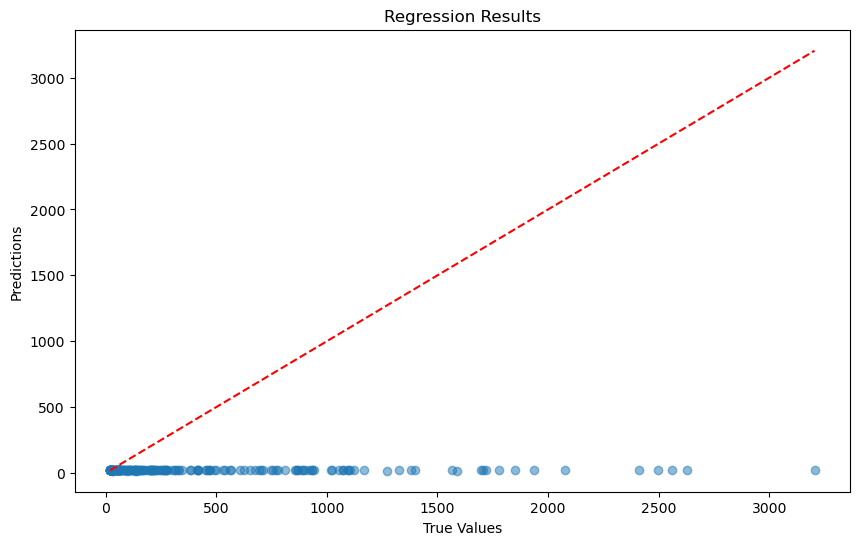

In [ ]:
plot_regression_results(best_model, cancer_dm.test_dataloader())